The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


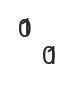

In [26]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

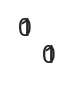

In [27]:
sns.set_palette(NEWPAL)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

In [28]:
FIGDIR = '../../../writing/230131_cedar_paper_1/figures/'

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve
def get_roc_curve_auc(df, targetcol, scorecol, neg=False):
    if neg:
        fpr, tpr, _ = roc_curve(df[targetcol], -1* df[scorecol])
        auc = roc_auc_score(df[targetcol], -1* df[scorecol])
        auc01 = roc_auc_score(df[targetcol], -1* df[scorecol], max_fpr=0.1)
    else:
        fpr, tpr, _ = roc_curve(df[targetcol], df[scorecol])
        auc = roc_auc_score(df[targetcol], df[scorecol])
        auc01 = roc_auc_score(df[targetcol], df[scorecol], max_fpr=0.1)
    return fpr, tpr, auc, auc01

# init

## reloading datasets

In [30]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')
nepdb = pd.read_csv('../data/mutant/230124_nepdb_filtered_scored.csv')
nepdb.head()

,Peptide,wild_type,HLA,agg_label,mut_len,wt_len,seq_id,Pos_mut,Peptide_mut,core_mut,...,core_blsm_mut_score,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,trueHLA_EL_rank
0,AFGSAHLFR,AFGSAHLYR,HLA-A3101,1,9,9,seq_1,0,AFGSAHLFR,AFGSAHLFR,...,3,65.555556,0.837778,0.455556,10.551759,0.214444,-0.278889,0.193333,-0.192222,0.2470
1,AIANRIKFK,AIANRIKSK,HLA-A1101,0,9,9,seq_4,0,AIANRIKFK,AIANRIKFK,...,-2,108.888889,1.802222,-0.044444,11.823055,-0.048889,0.125556,0.484444,-0.125556,0.1380
2,AICKPLHYV,AICKPLHYM,HLA-A0201,0,9,9,seq_5,0,AICKPLHYV,AICKPLHYV,...,1,130.000000,-0.735556,0.755556,8.530526,0.327778,0.046667,-0.017778,0.263333,0.3610
3,AIPAMVVPNV,AIPAMVVPNA,HLA-A0201,0,10,10,seq_6,0,AIPAMVVPNV,AIPAVVPNV,...,0,146.000000,-1.637000,1.590000,6.100000,0.431000,-0.385000,-0.067000,0.446000,2.2606
4,ALEVLQSIPY,APEVLQSIPY,HLA-A0101,0,10,10,seq_7,0,ALEVLQSIPY,ALEVLQSIY,...,-3,156.000000,-0.472000,0.740000,3.849983,0.292000,-0.062000,-0.096000,0.088000,0.6230


In [31]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230125_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230125_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230125_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230125_nepdb_aligned_icore.csv')

In [32]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_related_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_related_pepx.csv')
ibel_expr = pd.read_csv('../data/pepx/230125_ibel_normal_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_normal_pepx.csv')

In [485]:
cedar_aligned_expr = pd.read_csv('../data/pepx/230308_cedar_aligned_pepx_fold.csv')
prime_aligned_expr = pd.read_csv('../data/pepx/230308_prime_aligned_pepx.csv')
ibel_aligned_expr = pd.read_csv('../data/pepx/230125_ibel_aligned_pepx.csv')
nepdb_aligned_expr = pd.read_csv('../data/pepx/230308_nepdb_aligned_pepx.csv')

In [34]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

<AxesSubplot:>

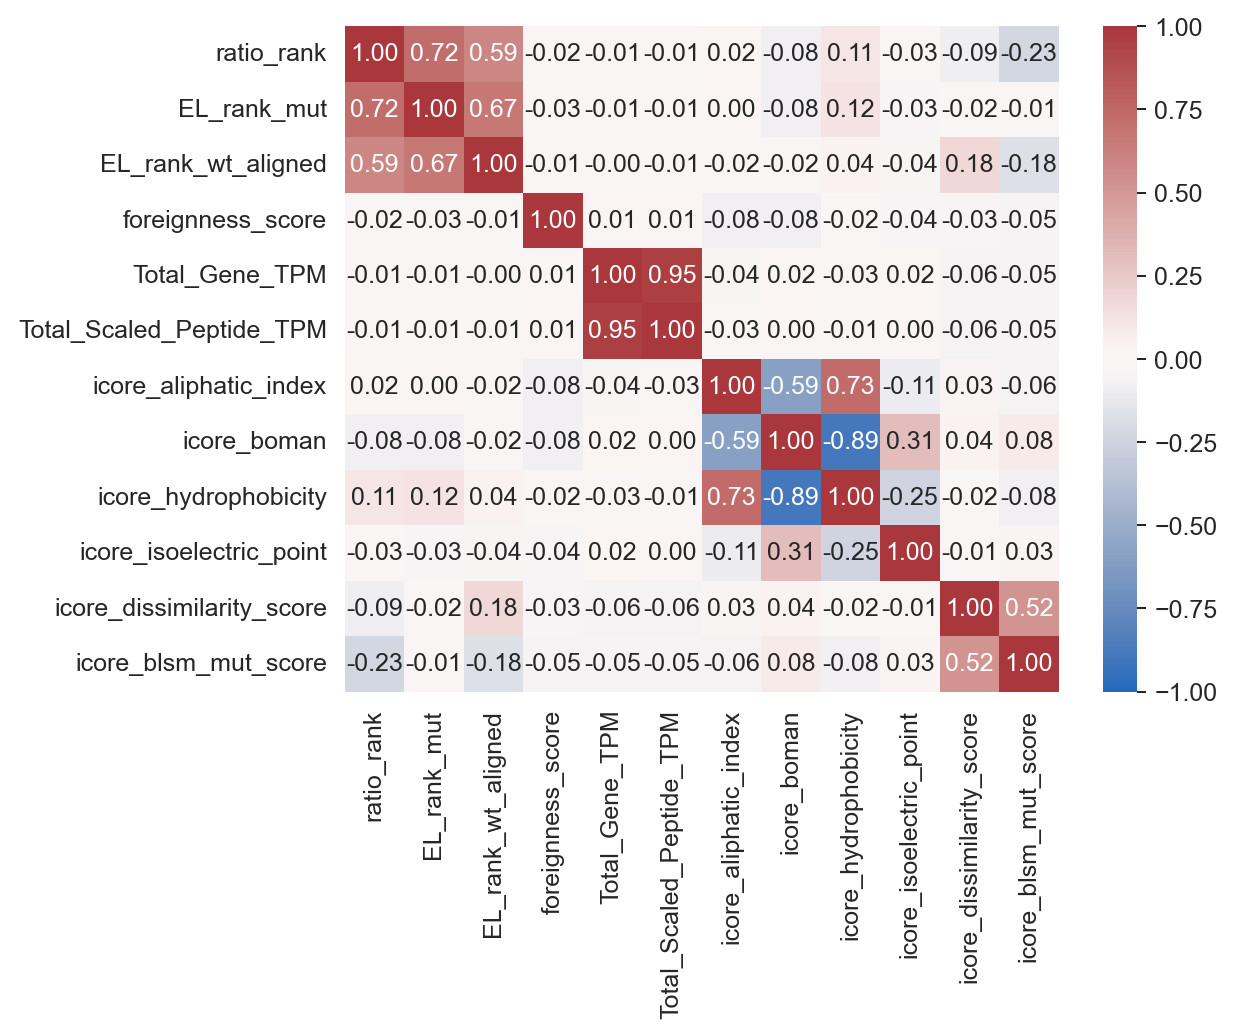

In [536]:
from scipy.stats import ttest_ind, mannwhitneyu
xd, _ = get_aa_properties(cedar_aligned_expr, 'icore_mut', False, 'icore_')
features=['ratio_rank', 'EL_rank_mut', 'EL_rank_wt_aligned', 'foreignness_score', 'Total_Gene_TPM', 'Total_Scaled_Peptide_TPM', 'icore_aliphatic_index', 'icore_boman', 'icore_hydrophobicity', 'icore_isoelectric_point', 'icore_dissimilarity_score', 'icore_blsm_mut_score']
corr= xd[features].corr(method='spearman')
sns.heatmap(corr, center=0, vmin=-1, vmax=1, cmap='vlag', annot=True, fmt='.2f')

In [ ]:
f,a = plt.subplots(4,3, figsize=(15,20))
a = a.ravel()
for feat, ax in zip(features, a.ravel()):
    if 'icore' not in feat:
        xd[f'Log_{feat}'] = xd[feat].apply(np.log)
        xd[f'Log_{feat}'].replace(-np.inf, -999,inplace=True)
        sns.boxplot(data=xd, y=f'Log_{feat}', x='agg_label', hue='agg_label', ax=ax)
        plt.setp(ax.patches, alpha=0.8)
        sns.swarmplot(data=xd, y=f'Log_{feat}', x='agg_label', hue='agg_label', ax=ax, size=3, edgecolor='k', dodge=True)
        ax.set_ylabel(f'Log_{feat}')
        a=xd.query('agg_label==0')[f'Log_{feat}'].values
        b=xd.query('agg_label==1')[f'Log_{feat}'].values
        auc = roc_auc_score(xd.agg_label.values, xd[f'Log_{feat}'].values)
    else:
        sns.boxplot(data=xd, y=feat, x='agg_label', hue='agg_label', ax=ax)
        plt.setp(ax.patches, alpha=0.8)
        sns.swarmplot(data=xd, y=feat, x='agg_label', hue='agg_label', ax=ax,  size=3, edgecolor='k', dodge=True)
        a=xd.query('agg_label==0')[feat].values
        b=xd.query('agg_label==1')[feat].values
        auc = roc_auc_score(xd.agg_label.values, xd[feat].values)


    pvalw = ttest_ind(a,b, equal_var=False)[1]
    pvalmwu = mannwhitneyu(a,b)[1]
    ax.set_title(f'{feat}: AUC={auc:.3f} \npWelch={pvalw:.3e}, pMWU={pvalmwu:.3e}')
f.tight_layout()

# redo conditions

In [83]:
cdt_base = (dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, 
                       add_rank=True, seq_col='Peptide', rank_col='trueHLA_EL_rank', hla_col='HLA',
                       target_col = 'agg_label', add_aaprop=False, remove_pep=False, standardize=True),
            None, 'Base')
cdt_cedar = (dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=False, invert=True,
                        mut_col = aa_cols+['EL_rank_wt_aligned','icore_dissimilarity_score','ratio_rank','Total_Gene_TPM']
                        ), # Here it should be icore similarity score because it's not dissimilarity that we have
            ics_shannon, 'OptCEDAR')

cdt_prime = (dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=True, invert=False,
                        mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score']),
            ics_shannon, 'OptPRIME')

cdt_general = (dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                          add_aaprop=False, remove_pep=False, standardize=True,
                          mask=False, invert=False,
                          mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank', 'Total_Gene_TPM']),
             None, 'General')

In [84]:
encoding_kwargs = dict(max_len=12, encoding='onehot', rank_col='EL_rank_mut', seq_col='icore_mut',
                       blosum_matrix=None, mask=False, add_rank=True, add_aaprop=False, 
                       remove_pep=False, standardize=True)

def final_bootstrap_wrapper(preds_df, filename,
                            ic_name, key, evalset,
                            n_rounds=10000, n_jobs=8, outdir=None):
    scores = preds_df.pred.values if 'pred' in preds_df.columns else preds_df['mean_pred'].values
    targets = preds_df.agg_label.values if 'agg_label' in preds_df.columns else preds_df['Immunogenicity'].values

    bootstrapped_df, mean_rocs = bootstrap_eval(y_score=scores,
                                                y_true=targets,
                                                n_rounds=n_rounds, n_jobs=n_jobs)
    bootstrapped_df['encoding'] = 'onehot'
    bootstrapped_df['weight'] = ic_name
    bootstrapped_df['pep_col'] = 'icore_mut'
    bootstrapped_df['rank_col'] = 'EL_rank_mut'
    bootstrapped_df['key'] = key
    bootstrapped_df['evalset'] = evalset.upper()
    if outdir is not None:
        bootstrapped_df.to_csv(
            f'{outdir}bootstrapping/{evalset}_bootstrapped_df_{filename}.csv',
            index=False)
        pkl_dump(mean_rocs,
                 f'{outdir}bootstrapping/{evalset}_mean_rocs_{filename}.pkl')

    return bootstrapped_df

In [103]:
# Quick individual checks for pvalues
from src.bootstrap import get_pval, plot_pval
# Redo CEDAR inv weighting vs none and get pval
encoding_kwargs = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=False, invert=True,
                        mut_col = aa_cols+['icore_dissimilarity_score', 'Total_Gene_TPM']
                        ) # Here it should be icore similarity score because it's not dissimilarity that we have

comp = []
for ics_dict,weight in zip([ics_shannon, None], [None, 'None']):
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                               max_depth=8, ccp_alpha=9.945e-6)
    
    # Training model and getting feature importances
    print('Training')
    if weight=='None': 
        encoding_kwargs['invert']=False
        encoding_kwargs['mask']=False
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned_expr, model,
                                                                ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=8)
    _, preds = evaluate_trained_models_sklearn(cedar_aligned_expr.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                               trained_models, ics_dict,
                                               cedar_aligned_expr,
                                               encoding_kwargs, concatenated=False,
                                               only_concat=False, n_jobs=8)
    bootstrapped_df = final_bootstrap_wrapper(preds, 'xd',
                                              weight, 'xd', 'CEDAR',
                                              n_rounds=10000, n_jobs=8, outdir=None)
    comp.append(bootstrapped_df)
    
get_pval(comp[0].auc.values, comp[1].auc.values), comp[0].auc.mean(), comp[1].auc.mean()

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


((0.04249999999999998, '*'), 0.7375124645540864, 0.7298803373018402)

In [138]:
from src.bootstrap import get_pval, plot_pval
# Redo CEDAR inv weighting vs none and get pval
a = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=False, invert=True,
                        mut_col = aa_cols+['icore_dissimilarity_score', 'Total_Gene_TPM']
                        ) # Here it should be icore similarity score because it's not dissimilarity that we have

b = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=False, invert=True,
                        mut_col = aa_cols+['Total_Gene_TPM']
                        ) # Here it should be icore similarity score because it's not dissimilarity that we have


comp = []
for encoding_kwargs, ics_dict, cdt in zip([a,b], [ics_shannon, ics_shannon], ['A', 'B']):
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                               max_depth=8, ccp_alpha=9.945e-6)
    
    # Training model and getting feature importances
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned_expr, model,
                                                                ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=8)
    _, preds = evaluate_trained_models_sklearn(cedar_aligned_expr.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                               trained_models, ics_dict,
                                               cedar_aligned_expr,
                                               encoding_kwargs, concatenated=False,
                                               only_concat=False, n_jobs=8)
    bootstrapped_df = final_bootstrap_wrapper(preds, 'A',
                                              weight, cdt, 'PRIME',
                                              n_rounds=10000, n_jobs=8, outdir=None)
    comp.append(bootstrapped_df)
print('cdt A (mask+icore scores) >> cdt B (None weighting + base features)')
get_pval(comp[0].auc.values, comp[1].auc.values), comp[0].auc.mean(), comp[1].auc.mean()

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
cdt A (mask+icore scores) >> cdt B (None weighting + base features)


((0.8634, 'ns'), 0.7375124645540864, 0.7389467447759966)

In [138]:
from src.bootstrap import get_pval, plot_pval
# Redo CEDAR inv weighting vs none and get pval
a = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=False, invert=True,
                        mut_col = aa_cols+['icore_dissimilarity_score', 'Total_Gene_TPM']
                        ) # Here it should be icore similarity score because it's not dissimilarity that we have

b = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=False, invert=True,
                        mut_col = aa_cols+['Total_Gene_TPM']
                        ) # Here it should be icore similarity score because it's not dissimilarity that we have


comp = []
for encoding_kwargs, ics_dict, cdt in zip([a,b], [ics_shannon, ics_shannon], ['A', 'B']):
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                               max_depth=8, ccp_alpha=9.945e-6)
    
    # Training model and getting feature importances
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned_expr, model,
                                                                ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=8)
    _, preds = evaluate_trained_models_sklearn(cedar_aligned_expr.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                               trained_models, ics_dict,
                                               cedar_aligned_expr,
                                               encoding_kwargs, concatenated=False,
                                               only_concat=False, n_jobs=8)
    bootstrapped_df = final_bootstrap_wrapper(preds, 'A',
                                              weight, cdt, 'PRIME',
                                              n_rounds=10000, n_jobs=8, outdir=None)
    comp.append(bootstrapped_df)
print('cdt A (mask+icore scores) >> cdt B (None weighting + base features)')
get_pval(comp[0].auc.values, comp[1].auc.values), comp[0].auc.mean(), comp[1].auc.mean()

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
cdt A (mask+icore scores) >> cdt B (None weighting + base features)


((0.8634, 'ns'), 0.7375124645540864, 0.7389467447759966)

# Redo p-values

Redo this way: With the gb_merged thing, compare for each condition against the base model (icore, aafreq+ic(rank)?) or (peptide, aafreq+p(rank))?

In [216]:

# retrain the basest of base models: 
encoding_kwargs = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='Peptide', rank_col='trueHLA_EL_rank', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True, mask=False, invert=False)
ics_dict = None

model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                               max_depth=8, ccp_alpha=9.945e-6)
    
# Training model and getting feature importances
trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                            ics_dict=ics_dict,
                                                            encoding_kwargs=encoding_kwargs,
                                                            n_jobs=8)
_, preds = evaluate_trained_models_sklearn(prime_aligned.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                           trained_models, ics_dict, cedar_aligned,
                                           encoding_kwargs, concatenated=False,
                                           only_concat=False, n_jobs=8)
base_pep_prime_aligned = final_bootstrap_wrapper(preds, '??xd',
                                              'None', 'base_model_Peptide_PRIME', evalname,
                                              n_rounds=10000, n_jobs=8, outdir=None)

#######
encoding_kwargs = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True, mask=False, invert=False)
ics_dict = None

model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                               max_depth=8, ccp_alpha=9.945e-6)
    
# Training model and getting feature importances
trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                            ics_dict=ics_dict,
                                                            encoding_kwargs=encoding_kwargs,
                                                            n_jobs=8)
_, preds = evaluate_trained_models_sklearn(prime_aligned.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                           trained_models, ics_dict, cedar_aligned,
                                           encoding_kwargs, concatenated=False,
                                           only_concat=False, n_jobs=8)

base_icore_prime_aligned = final_bootstrap_wrapper(preds, '??xd',
                                              'None', 'base_model_ICORE_PRIME', evalname,
                                              n_rounds=10000, n_jobs=8, outdir=None)
base_pep_prime_aligned.auc.mean(), base_pep_prime_aligned.auc.median(), base_icore_prime_aligned.auc.mean(), base_icore_prime_aligned.auc.median() 

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


(0.6738090960331687,
 0.6740093885711926,
 0.6689619883012272,
 0.6691824946784815)

In [234]:
base = {'Peptide':{'CEDAR': ...,
                   'PRIME': ...,
                   'NEPDB': ...},
        'ICORE':{'CEDAR':pd.read_csv('../output/230327_aligned_icore_exprscore_mutscore_filtered/bootstrapping/CEDAR_bootstrapped_df_cedar_onehot_None_icore_mut_EL_rank_mut_only_rank.csv'),
                 'PRIME':pd.read_csv('../output/230327_aligned_icore_exprscore_mutscore_filtered/bootstrapping/PRIME_bootstrapped_df_cedar_onehot_None_icore_mut_EL_rank_mut_only_rank.csv'),
                 'NEPDB':pd.read_csv('../output/230327_aligned_icore_exprscore_mutscore_filtered/bootstrapping/NEPDB_bootstrapped_df_cedar_onehot_None_icore_mut_EL_rank_mut_only_rank.csv')}}


# retrain the basest of base models: 
encoding_kwargs = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='Peptide', rank_col='trueHLA_EL_rank', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True, mask=False, invert=False)
ics_dict = None

model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                               max_depth=8, ccp_alpha=9.945e-6)
    
# Training model and getting feature importances
trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned_expr, model,
                                                            ics_dict=ics_dict,
                                                            encoding_kwargs=encoding_kwargs,
                                                            n_jobs=8)

for evalset, evalname in zip([cedar_aligned_expr, prime_aligned_expr, nepdb_aligned_expr], ['CEDAR', 'PRIME', 'NEPDB']):
    if evalname != 'CEDAR':
        evalset = evalset.query('Peptide not in @cedar_aligned_expr.Peptide.values')
    _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                               trained_models, ics_dict, cedar_aligned_expr,
                                               encoding_kwargs, concatenated=False,
                                               only_concat=False, n_jobs=8)
    base['Peptide'][evalname] = final_bootstrap_wrapper(preds, '??xd',
                                              'None', 'base_model_Peptide_trueHLA', evalname,
                                              n_rounds=10000, n_jobs=8, outdir=None)

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [410]:
# Here I realise I am missing some conditiosn from the 230327_aligned_icore_exprmutscore_filtered because I was only doing combinations that were missing from the previous results in 230125_exprscore
# So I copy them and get the mutscore
total_df = pd.read_csv('../output/230327_aligned_icore_exprscore_mutscore_filtered/total_df.csv')
# total_df_rest = pd.read_csv('../output/230327_aligned_icore_exprscore_mutscore_filtered/total_df_filtered.csv')
# total_df_rest['key']=total_df_rest['key'].str.replace(' ','_')

In [412]:
merged_df = pd.concat([total_df, total_df_rest.query('evalset!="IBEL"')])
merged_df['weight'] = merged_df['weight'].str.replace(' ','-')
gb = []
for evalset in merged_df.evalset.unique():
    tmp = merged_df.query('evalset==@evalset')
    tmp = tmp.groupby(['weight', 'key']).agg(mean_auc=('auc','mean'), mean_auc01=('auc_01','mean'))
    tmp.columns = [f'{x}_{evalset}' for x in tmp.columns]
    gb.append(tmp)
gb_merged = pd.concat(gb, axis=1)
# get compromise
gb_merged['mean_auc_agg'] = .5*(gb_merged['mean_auc_CEDAR']+gb_merged['mean_auc_PRIME'])
gb_merged['mean_auc_std'] = gb_merged.apply(lambda x: np.std([x['mean_auc_CEDAR'],x['mean_auc_PRIME']]), axis=1)
gb_merged['Compromise'] = gb_merged.apply(lambda x: .33*x['mean_auc_CEDAR']+.33 * x['mean_auc_agg'] + .33* (1-x['mean_auc_std']), axis = 1)
gb_merged.reset_index().query('weight=="None"').set_index(['key']).sort_values('Compromise', ascending=False).head(25)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB']]

,mean_auc_CEDAR,mean_auc_PRIME,mean_auc_NEPDB
key,,,
icore_dissimilarity_score-icore_blsm_mut_score-Total_Scaled_Peptide_TPM,0.727096,0.715249,0.742815
icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM,0.728096,0.712474,0.748349
icore_dissimilarity_score-icore_blsm_mut_score-icore_mut_score-Total_Scaled_Peptide_TPM,0.724829,0.715702,0.744592
icore_dissimilarity_score-icore_blsm_mut_score-icore_mut_score-Total_Gene_TPM,0.725619,0.714446,0.747620
icore_dissimilarity_score-icore_blsm_mut_score-icore_mut_score-Total_Peptide_TPM,0.725622,0.714224,0.745893
icore_dissimilarity_score-icore_blsm_mut_score-Total_Peptide_TPM,0.727685,0.712129,0.746356
icore_dissimilarity_score-ratio_rank-Total_Scaled_Peptide_TPM,0.718779,0.717450,0.757004
icore_dissimilarity_score-icore_mut_score-Total_Scaled_Peptide_TPM,0.726533,0.708879,0.746291
icore_dissimilarity_score-icore_blsm_mut_score-icore_mut_score,0.720768,0.714636,0.698076


In [413]:
bdir = '../output/230327_aligned_icore_exprscore_mutscore_filtered/bootstrapping/'
bdir2 = '../output/230327_aligned_icore_exprscore_mutscore_filtered/bootstrapping_copy/'
def get_df(weight, key, evalset): 
    try:
        df=pd.read_csv(f'{bdir}{evalset}_bootstrapped_df_cedar_onehot_{weight}_icore_mut_EL_rank_mut_{key}.csv')
    except:
        df=pd.read_csv(f'{bdir2}{evalset}_bootstrapped_df_cedar_onehot_{weight}_icore_mut_EL_rank_mut_{key}.csv')
    return df

def do_pval(weight, key, evalset, input_kind):
    base_aucs = base[input_kind][evalset].auc.values
    comp_aucs = get_df(weight, key, evalset).auc.values
    pval, sig = get_pval(comp_aucs, base_aucs)
    return pval, sig
gb_merged.reset_index(['weight', 'key'], inplace=True)
# get pvl
gb_merged[['pval_base_pep_CEDAR', 'sig_base_pep_CEDAR']] = gb_merged.apply(lambda x: do_pval(x['weight'], x['key'], 'CEDAR', 'Peptide'), axis=1, result_type='expand')
gb_merged[['pval_base_ICORE_CEDAR', 'sig_base_ICORE_CEDAR']] = gb_merged.apply(lambda x: do_pval(x['weight'], x['key'], 'CEDAR', 'ICORE'), axis=1, result_type='expand')
gb_merged[['pval_base_pep_PRIME', 'sig_base_pep_PRIME']] = gb_merged.apply(lambda x: do_pval(x['weight'], x['key'], 'PRIME', 'Peptide'), axis=1, result_type='expand')
gb_merged[['pval_base_ICORE_PRIME', 'sig_base_ICORE_PRIME']] = gb_merged.apply(lambda x: do_pval(x['weight'], x['key'], 'PRIME', 'ICORE'), axis=1, result_type='expand')
gb_merged.set_index(['weight','key'],inplace=True)

In [417]:
gb_merged.reset_index().query('key.str.contains("ratio_rank")').set_index(['weight', 'key'])[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB','pval_base_pep_CEDAR', 'pval_base_ICORE_CEDAR']].sort_values('mean_auc_CEDAR',ascending=False).head(10)
                                                                                              

mean_auc_CEDAR  \
weight           key                                                                  
Inverted-Shannon aa_props-icore_dissimilarity_score-icore_blsm_m...        0.737055   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...        0.737044   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...        0.737020   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...        0.737003   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...        0.736693   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...        0.736403   
                 aa_props-icore_dissimilarity_score-ratio_rank-E...        0.736273   
                 aa_props-icore_mut_score-ratio_rank-EL_rank_wt_...        0.736272   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...        0.735982   
                 aa_props-icore_mut_score-ratio_rank-EL_rank_wt_...        0.735791   

                                                                     mean_auc_PRIME  \
weight           key                                                                  
Inverted-Shannon aa_props-icore_dissimilarity_score-icore_blsm_m...        0.653905   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...        0.653060   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...        0.653700   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...        0.652690   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...        0.646831   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...        0.646731   
                 aa_props-icore_dissimilarity_score-ratio_rank-E...        0.653536   
                 aa_props-icore_mut_score-ratio_rank-EL_rank_wt_...        0.644433   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...        0.655108   
                 aa_props-icore_mut_score-ratio_rank-EL_rank_wt_...        0.643872   

                                                                     mean_auc_NEPDB  \
weight           key                                                                  
Inverted-Shannon aa_props-icore_dissimilarity_score-icore_blsm_m...        0.698825   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...        0.704310   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...        0.697335   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...        0.703765   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...        0.682182   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...        0.681455   
                 aa_props-icore_dissimilarity_score-ratio_rank-E...        0.706241   
                 aa_props-icore_mut_score-ratio_rank-EL_rank_wt_...        0.692346   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...        0.690844   
                 aa_props-icore_mut_score-ratio_rank-EL_rank_wt_...        0.692092   

                                                                     pval_base_pep_CEDAR  \
weight           key                                                                       
Inverted-Shannon aa_props-icore_dissimilarity_score-icore_blsm_m...               0.0111   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...               0.0110   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...               0.0113   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...               0.0113   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...               0.0117   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...               0.0120   
                 aa_props-icore_dissimilarity_score-ratio_rank-E...               0.0122   
                 aa_props-icore_mut_score-ratio_rank-EL_rank_wt_...               0.0123   
              

## THESE HERE ARE THE FINAL BEST MODELS , NO MORE RERUNS OR CHANGE.

In [424]:
with_ratio = gb_merged.reset_index().query('key.str.contains("ratio_rank")').set_index(['weight','key'])

print('mean_auc_CEDAR')
display(with_ratio.sort_values('mean_auc_CEDAR', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

print('mean_auc_PRIME')
display(with_ratio.sort_values('mean_auc_PRIME', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

print('mean_auc_NEPDB')
display(with_ratio.sort_values('mean_auc_NEPDB', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

print('Compromise')
display(with_ratio.sort_values('Compromise', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

mean_auc_CEDAR


mean_auc_CEDAR  \
weight           key                                                                  
Inverted-Shannon aa_props-icore_dissimilarity_score-icore_blsm_m...        0.737055   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...        0.737044   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...        0.737020   

                                                                     mean_auc_PRIME  \
weight           key                                                                  
Inverted-Shannon aa_props-icore_dissimilarity_score-icore_blsm_m...        0.653905   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...        0.653060   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...        0.653700   

                                                                     mean_auc_NEPDB  \
weight           key                                                                  
Inverted-Shannon aa_props-icore_dissimilarity_score-icore_blsm_m...        0.698825   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...        0.704310   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...        0.697335   

                                                                     pval_base_pep_CEDAR  \
weight           key                                                                       
Inverted-Shannon aa_props-icore_dissimilarity_score-icore_blsm_m...               0.0111   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...               0.0110   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...               0.0113   

                                                                     pval_base_pep_PRIME  \
weight           key                                                                       
Inverted-Shannon aa_props-icore_dissimilarity_score-icore_blsm_m...               0.6674   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...               0.6705   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...               0.6674   

                                                                     pval_base_ICORE_CEDAR  \
weight           key                                                                         
Inverted-Shannon aa_props-icore_dissimilarity_score-icore_blsm_m...                 0.0147   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...                 0.0141   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...                 0.0151   

                                                                     pval_base_ICORE_PRIME  
weight           key                                                                        
Inverted-Shannon aa_props-icore_dissimilarity_score-icore_blsm_m...                 0.9182  
                 aa_props-icore_dissimilarity_score-icore_mut_sc...                 0.9188  
                 aa_props-icore_dissimilarity_score-icore_blsm_m...                 0.9195

mean_auc_PRIME


mean_auc_CEDAR  \
weight key                                                                  
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...        0.709348   
       icore_dissimilarity_score-ratio_rank-Total_Pept...        0.708912   
       icore_dissimilarity_score-ratio_rank-Total_Scal...        0.709724   

                                                           mean_auc_PRIME  \
weight key                                                                  
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...        0.725922   
       icore_dissimilarity_score-ratio_rank-Total_Pept...        0.725659   
       icore_dissimilarity_score-ratio_rank-Total_Scal...        0.725622   

                                                           mean_auc_NEPDB  \
weight key                                                                  
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...        0.770625   
       icore_dissimilarity_score-ratio_rank-Total_Pept...        0.768367   
       icore_dissimilarity_score-ratio_rank-Total_Scal...        0.773047   

                                                           pval_base_pep_CEDAR  \
weight key                                                                       
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...               0.2724   
       icore_dissimilarity_score-ratio_rank-Total_Pept...               0.2795   
       icore_dissimilarity_score-ratio_rank-Total_Scal...               0.2659   

                                                           pval_base_pep_PRIME  \
weight key                                                                       
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...               0.2123   
       icore_dissimilarity_score-ratio_rank-Total_Pept...               0.2132   
       icore_dissimilarity_score-ratio_rank-Total_Scal...               0.2126   

                                                           pval_base_ICORE_CEDAR  \
weight key                                                                         
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...                 0.9428   
       icore_dissimilarity_score-ratio_rank-Total_Pept...                 0.9496   
       icore_dissimilarity_score-ratio_rank-Total_Scal...                 0.9372   

                                                           pval_base_ICORE_PRIME  
weight key                                                                        
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...                 0.0993  
       icore_dissimilarity_score-ratio_rank-Total_Pept...                 0.1012  
       icore_dissimilarity_score-ratio_rank-Total_Scal...                 0.1048

mean_auc_NEPDB


mean_auc_CEDAR  \
weight key                                                                  
Mask   icore_dissimilarity_score-ratio_rank-Total_Scal...        0.709724   
       icore_dissimilarity_score-ratio_rank-Total_Gene...        0.709348   
       icore_dissimilarity_score-ratio_rank-Total_Pept...        0.708912   

                                                           mean_auc_PRIME  \
weight key                                                                  
Mask   icore_dissimilarity_score-ratio_rank-Total_Scal...        0.725622   
       icore_dissimilarity_score-ratio_rank-Total_Gene...        0.725922   
       icore_dissimilarity_score-ratio_rank-Total_Pept...        0.725659   

                                                           mean_auc_NEPDB  \
weight key                                                                  
Mask   icore_dissimilarity_score-ratio_rank-Total_Scal...        0.773047   
       icore_dissimilarity_score-ratio_rank-Total_Gene...        0.770625   
       icore_dissimilarity_score-ratio_rank-Total_Pept...        0.768367   

                                                           pval_base_pep_CEDAR  \
weight key                                                                       
Mask   icore_dissimilarity_score-ratio_rank-Total_Scal...               0.2659   
       icore_dissimilarity_score-ratio_rank-Total_Gene...               0.2724   
       icore_dissimilarity_score-ratio_rank-Total_Pept...               0.2795   

                                                           pval_base_pep_PRIME  \
weight key                                                                       
Mask   icore_dissimilarity_score-ratio_rank-Total_Scal...               0.2126   
       icore_dissimilarity_score-ratio_rank-Total_Gene...               0.2123   
       icore_dissimilarity_score-ratio_rank-Total_Pept...               0.2132   

                                                           pval_base_ICORE_CEDAR  \
weight key                                                                         
Mask   icore_dissimilarity_score-ratio_rank-Total_Scal...                 0.9372   
       icore_dissimilarity_score-ratio_rank-Total_Gene...                 0.9428   
       icore_dissimilarity_score-ratio_rank-Total_Pept...                 0.9496   

                                                           pval_base_ICORE_PRIME  
weight key                                                                        
Mask   icore_dissimilarity_score-ratio_rank-Total_Scal...                 0.1048  
       icore_dissimilarity_score-ratio_rank-Total_Gene...                 0.0993  
       icore_dissimilarity_score-ratio_rank-Total_Pept...                 0.1012

Compromise


mean_auc_CEDAR  \
weight key                                                                  
None   icore_dissimilarity_score-ratio_rank-Total_Scal...        0.718779   
       icore_dissimilarity_score-ratio_rank-Total_Gene...        0.719566   
       icore_dissimilarity_score-ratio_rank-Total_Pept...        0.719421   

                                                           mean_auc_PRIME  \
weight key                                                                  
None   icore_dissimilarity_score-ratio_rank-Total_Scal...        0.717450   
       icore_dissimilarity_score-ratio_rank-Total_Gene...        0.715119   
       icore_dissimilarity_score-ratio_rank-Total_Pept...        0.715083   

                                                           mean_auc_NEPDB  \
weight key                                                                  
None   icore_dissimilarity_score-ratio_rank-Total_Scal...        0.757004   
       icore_dissimilarity_score-ratio_rank-Total_Gene...        0.762668   
       icore_dissimilarity_score-ratio_rank-Total_Pept...        0.758970   

                                                           pval_base_pep_CEDAR  \
weight key                                                                       
None   icore_dissimilarity_score-ratio_rank-Total_Scal...               0.1214   
       icore_dissimilarity_score-ratio_rank-Total_Gene...               0.1123   
       icore_dissimilarity_score-ratio_rank-Total_Pept...               0.1145   

                                                           pval_base_pep_PRIME  \
weight key                                                                       
None   icore_dissimilarity_score-ratio_rank-Total_Scal...               0.2525   
       icore_dissimilarity_score-ratio_rank-Total_Gene...               0.2659   
       icore_dissimilarity_score-ratio_rank-Total_Pept...               0.2664   

                                                           pval_base_ICORE_CEDAR  \
weight key                                                                         
None   icore_dissimilarity_score-ratio_rank-Total_Scal...                 0.5882   
       icore_dissimilarity_score-ratio_rank-Total_Gene...                 0.5136   
       icore_dissimilarity_score-ratio_rank-Total_Pept...                 0.5276   

                                                           pval_base_ICORE_PRIME  
weight key                                                                        
None   icore_dissimilarity_score-ratio_rank-Total_Scal...                 0.0927  
       icore_dissimilarity_score-ratio_rank-Total_Gene...                 0.1223  
       icore_dissimilarity_score-ratio_rank-Total_Pept...                 0.1273

In [414]:
print('mean_auc_CEDAR')
display(gb_merged.sort_values('mean_auc_CEDAR', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

print('mean_auc_PRIME')
display(gb_merged.sort_values('mean_auc_PRIME', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

print('mean_auc_NEPDB')
display(gb_merged.sort_values('mean_auc_NEPDB', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

print('Compromise')
display(gb_merged.sort_values('Compromise', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

mean_auc_CEDAR


mean_auc_CEDAR  \
weight           key                                                                  
Inverted-Shannon aa_props-icore_blsm_mut_score-foreignness_score...        0.739297   
                 aliphatic_index-boman-hydrophobicity-isoelectri...        0.739015   
                 aa_props-EL_rank_wt_aligned-Total_Peptide_TPM             0.739015   

                                                                     mean_auc_PRIME  \
weight           key                                                                  
Inverted-Shannon aa_props-icore_blsm_mut_score-foreignness_score...        0.642107   
                 aliphatic_index-boman-hydrophobicity-isoelectri...        0.640601   
                 aa_props-EL_rank_wt_aligned-Total_Peptide_TPM             0.640601   

                                                                     mean_auc_NEPDB  \
weight           key                                                                  
Inverted-Shannon aa_props-icore_blsm_mut_score-foreignness_score...        0.675921   
                 aliphatic_index-boman-hydrophobicity-isoelectri...        0.687808   
                 aa_props-EL_rank_wt_aligned-Total_Peptide_TPM             0.687808   

                                                                     pval_base_pep_CEDAR  \
weight           key                                                                       
Inverted-Shannon aa_props-icore_blsm_mut_score-foreignness_score...               0.0081   
                 aliphatic_index-boman-hydrophobicity-isoelectri...               0.0082   
                 aa_props-EL_rank_wt_aligned-Total_Peptide_TPM                    0.0082   

                                                                     pval_base_pep_PRIME  \
weight           key                                                                       
Inverted-Shannon aa_props-icore_blsm_mut_score-foreignness_score...               0.7309   
                 aliphatic_index-boman-hydrophobicity-isoelectri...               0.7405   
                 aa_props-EL_rank_wt_aligned-Total_Peptide_TPM                    0.7405   

                                                                     pval_base_ICORE_CEDAR  \
weight           key                                                                         
Inverted-Shannon aa_props-icore_blsm_mut_score-foreignness_score...                 0.0094   
                 aliphatic_index-boman-hydrophobicity-isoelectri...                 0.0076   
                 aa_props-EL_rank_wt_aligned-Total_Peptide_TPM                      0.0076   

                                                                     pval_base_ICORE_PRIME  
weight           key                                                                        
Inverted-Shannon aa_props-icore_blsm_mut_score-foreignness_score...                 0.9591  
                 aliphatic_index-boman-hydrophobicity-isoelectri...                 0.9639  
                 aa_props-EL_rank_wt_aligned-Total_Peptide_TPM                      0.9639

mean_auc_PRIME


mean_auc_CEDAR  \
weight key                                                                  
Mask   icore_dissimilarity_score-icore_blsm_mut_score            0.709356   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.716777   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.718161   

                                                           mean_auc_PRIME  \
weight key                                                                  
Mask   icore_dissimilarity_score-icore_blsm_mut_score            0.729706   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.727397   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.726844   

                                                           mean_auc_NEPDB  \
weight key                                                                  
Mask   icore_dissimilarity_score-icore_blsm_mut_score            0.716671   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.763450   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.766163   

                                                           pval_base_pep_CEDAR  \
weight key                                                                       
Mask   icore_dissimilarity_score-icore_blsm_mut_score                   0.2710   
       icore_dissimilarity_score-icore_blsm_mut_score-...               0.1460   
       icore_dissimilarity_score-icore_blsm_mut_score-...               0.1274   

                                                           pval_base_pep_PRIME  \
weight key                                                                       
Mask   icore_dissimilarity_score-icore_blsm_mut_score                   0.1851   
       icore_dissimilarity_score-icore_blsm_mut_score-...               0.2014   
       icore_dissimilarity_score-icore_blsm_mut_score-...               0.2040   

                                                           pval_base_ICORE_CEDAR  \
weight key                                                                         
Mask   icore_dissimilarity_score-icore_blsm_mut_score                     0.9551   
       icore_dissimilarity_score-icore_blsm_mut_score-...                 0.6706   
       icore_dissimilarity_score-icore_blsm_mut_score-...                 0.5930   

                                                           pval_base_ICORE_PRIME  
weight key                                                                        
Mask   icore_dissimilarity_score-icore_blsm_mut_score                     0.0676  
       icore_dissimilarity_score-icore_blsm_mut_score-...                 0.1129  
       icore_dissimilarity_score-icore_blsm_mut_score-...                 0.1216

mean_auc_NEPDB


mean_auc_CEDAR  \
weight key                                                                  
Mask   icore_dissimilarity_score-ratio_rank-Total_Scal...        0.709724   
       icore_dissimilarity_score-Total_Scaled_Peptide_TPM        0.716449   
       icore_dissimilarity_score-ratio_rank-Total_Gene...        0.709348   

                                                           mean_auc_PRIME  \
weight key                                                                  
Mask   icore_dissimilarity_score-ratio_rank-Total_Scal...        0.725622   
       icore_dissimilarity_score-Total_Scaled_Peptide_TPM        0.721800   
       icore_dissimilarity_score-ratio_rank-Total_Gene...        0.725922   

                                                           mean_auc_NEPDB  \
weight key                                                                  
Mask   icore_dissimilarity_score-ratio_rank-Total_Scal...        0.773047   
       icore_dissimilarity_score-Total_Scaled_Peptide_TPM        0.771830   
       icore_dissimilarity_score-ratio_rank-Total_Gene...        0.770625   

                                                           pval_base_pep_CEDAR  \
weight key                                                                       
Mask   icore_dissimilarity_score-ratio_rank-Total_Scal...               0.2659   
       icore_dissimilarity_score-Total_Scaled_Peptide_TPM               0.1533   
       icore_dissimilarity_score-ratio_rank-Total_Gene...               0.2724   

                                                           pval_base_pep_PRIME  \
weight key                                                                       
Mask   icore_dissimilarity_score-ratio_rank-Total_Scal...               0.2126   
       icore_dissimilarity_score-Total_Scaled_Peptide_TPM               0.2280   
       icore_dissimilarity_score-ratio_rank-Total_Gene...               0.2123   

                                                           pval_base_ICORE_CEDAR  \
weight key                                                                         
Mask   icore_dissimilarity_score-ratio_rank-Total_Scal...                 0.9372   
       icore_dissimilarity_score-Total_Scaled_Peptide_TPM                 0.6932   
       icore_dissimilarity_score-ratio_rank-Total_Gene...                 0.9428   

                                                           pval_base_ICORE_PRIME  
weight key                                                                        
Mask   icore_dissimilarity_score-ratio_rank-Total_Scal...                 0.1048  
       icore_dissimilarity_score-Total_Scaled_Peptide_TPM                 0.1501  
       icore_dissimilarity_score-ratio_rank-Total_Gene...                 0.0993

Compromise


mean_auc_CEDAR  \
weight key                                                                  
None   icore_dissimilarity_score-icore_blsm_mut_score-...        0.727096   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.728096   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.724829   

                                                           mean_auc_PRIME  \
weight key                                                                  
None   icore_dissimilarity_score-icore_blsm_mut_score-...        0.715249   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.712474   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.715702   

                                                           mean_auc_NEPDB  \
weight key                                                                  
None   icore_dissimilarity_score-icore_blsm_mut_score-...        0.742815   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.748349   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.744592   

                                                           pval_base_pep_CEDAR  \
weight key                                                                       
None   icore_dissimilarity_score-icore_blsm_mut_score-...               0.0466   
       icore_dissimilarity_score-icore_blsm_mut_score-...               0.0417   
       icore_dissimilarity_score-icore_blsm_mut_score-...               0.0621   

                                                           pval_base_pep_PRIME  \
weight key                                                                       
None   icore_dissimilarity_score-icore_blsm_mut_score-...               0.2590   
       icore_dissimilarity_score-icore_blsm_mut_score-...               0.2752   
       icore_dissimilarity_score-icore_blsm_mut_score-...               0.2565   

                                                           pval_base_ICORE_CEDAR  \
weight key                                                                         
None   icore_dissimilarity_score-icore_blsm_mut_score-...                 0.0354   
       icore_dissimilarity_score-icore_blsm_mut_score-...                 0.0209   
       icore_dissimilarity_score-icore_blsm_mut_score-...                 0.1160   

                                                           pval_base_ICORE_PRIME  
weight key                                                                        
None   icore_dissimilarity_score-icore_blsm_mut_score-...                 0.1367  
       icore_dissimilarity_score-icore_blsm_mut_score-...                 0.1847  
       icore_dissimilarity_score-icore_blsm_mut_score-...                 0.1365

In [430]:
base['Peptide']['PRIME'].auc.describe()

count    10000.000000
mean         0.677925
std          0.039634
min          0.509039
25%          0.651974
50%          0.679269
75%          0.704565
max          0.805980
Name: auc, dtype: float64

In [436]:
total_df_rest

,auc,prauc,AP,auc_01,f1,accuracy,precision,recall,encoding,weight,pep_col,rank_col,key,evalset
0,0.731409,0.400098,0.401993,0.573545,0.060703,0.803213,0.542857,0.032149,onehot,Inverted Shannon,icore_mut,EL_rank_mut,only_rank,CEDAR
1,0.723426,0.404860,0.406865,0.582754,0.081566,0.811580,0.781250,0.043029,onehot,Inverted Shannon,icore_mut,EL_rank_mut,only_rank,CEDAR
2,0.740974,0.417502,0.419239,0.584637,0.077796,0.809572,0.685714,0.041237,onehot,Inverted Shannon,icore_mut,EL_rank_mut,only_rank,CEDAR
3,0.743116,0.453806,0.455251,0.590532,0.086957,0.796185,0.805556,0.045959,onehot,Inverted Shannon,icore_mut,EL_rank_mut,only_rank,CEDAR
4,0.740777,0.413482,0.415588,0.574016,0.085106,0.798527,0.622222,0.045677,onehot,Inverted Shannon,icore_mut,EL_rank_mut,only_rank,CEDAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12479995,0.647312,0.140891,0.202068,0.564395,0.000000,0.922414,0.000000,0.000000,onehot,None,icore_mut,EL_rank_mut,aliphatic_index-boman-hydrophobicity-isoelectr...,NEPDB
12479996,0.618396,0.111682,0.141137,0.516385,0.000000,0.896552,0.000000,0.000000,onehot,None,icore_mut,EL_rank_mut,aliphatic_index-boman-hydrophobicity-isoelectr...,NEPDB
12479997,0.709740,0.340659,0.363263,0.586466,0.000000,0.905172,0.000000,0.000000,onehot,None,icore_mut,EL_rank_mut,aliphatic_index-boman-hydrophobicity-isoelectr...,NEPDB
12479998,0.719007,0.232077,0.299574,0.560355,0.000000,0.879310,0.000000,0.000000,onehot,None,icore_mut,EL_rank_mut,aliphatic_index-boman-hydrophobicity-isoelectr...,NEPDB


In [435]:
get_pval(total_df_rest.query('key=="icore_dissimilarity_score-icore_blsm_mut_score-Total_Scaled_Peptide_TPM" and weight =="None" and evalset == "PRIME"').auc.values, base['Peptide']['PRIME'].auc.values)

(0.259, 'ns')

In [426]:
for evalset in ['CEDAR', 'PRIME']:
    for input_ in ['pep', 'ICORE']:
        df = gb_merged.query(f'pval_base_{input_}_{evalset} < 0.05').sort_values(f'mean_auc_{evalset}', ascending=False).head(1)
        if len(df)==0:
            df = gb_merged.loc[[gb_merged[f'pval_base_{input_}_{evalset}'].idxmin()]]
        print(evalset, input_, 'p=', df[f'pval_base_{input_}_{evalset}'].item(), 'siglevel=', df[f'sig_base_{input_}_{evalset}'].item())
        display(df[['mean_auc_CEDAR', 'mean_auc01_CEDAR', 'mean_auc_PRIME', 'mean_auc01_PRIME', 'mean_auc_NEPDB', 'mean_auc01_NEPDB']])
        
        
for evalset in ['CEDAR', 'PRIME']:
    for input_ in ['pep', 'ICORE']:
        df = gb_merged.query(f'pval_base_{input_}_{evalset} < 0.05').sort_values(f'Compromise', ascending=False).head(1)
        if len(df)==0:
            df = gb_merged.loc[[gb_merged[f'pval_base_{input_}_{evalset}'].idxmin()]]
        print('COMPROMISE', evalset, input_, 'p=', df[f'pval_base_{input_}_{evalset}'].item(), 'siglevel=', df[f'sig_base_{input_}_{evalset}'].item())
        display(df[['mean_auc_CEDAR', 'mean_auc01_CEDAR', 'mean_auc_PRIME', 'mean_auc01_PRIME', 'mean_auc_NEPDB', 'mean_auc01_NEPDB']])

CEDAR pep p= 0.008099999999999996 siglevel= **


,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,,,,,,
Inverted-Shannon,aa_props-icore_blsm_mut_score-foreignness_score-Total_Gene_TPM,0.739297,0.581713,0.642107,0.512488,0.675921,0.529298


CEDAR ICORE p= 0.009399999999999964 siglevel= **


,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,,,,,,
Inverted-Shannon,aa_props-icore_blsm_mut_score-foreignness_score-Total_Gene_TPM,0.739297,0.581713,0.642107,0.512488,0.675921,0.529298


PRIME pep p= 0.18510000000000004 siglevel= ns


,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,,,,,,
Mask,icore_dissimilarity_score-icore_blsm_mut_score,0.709356,0.565538,0.729706,0.594233,0.716671,0.615072


PRIME ICORE p= 0.057499999999999996 siglevel= ns


,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,,,,,,
None,icore_dissimilarity_score,0.718875,0.58395,0.712911,0.581058,0.707693,0.588372


COMPROMISE CEDAR pep p= 0.046599999999999975 siglevel= *


,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,,,,,,
None,icore_dissimilarity_score-icore_blsm_mut_score-Total_Scaled_Peptide_TPM,0.727096,0.577801,0.715249,0.581739,0.742815,0.592627


COMPROMISE CEDAR ICORE p= 0.03539999999999999 siglevel= *


,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,,,,,,
None,icore_dissimilarity_score-icore_blsm_mut_score-Total_Scaled_Peptide_TPM,0.727096,0.577801,0.715249,0.581739,0.742815,0.592627


COMPROMISE PRIME pep p= 0.18510000000000004 siglevel= ns


,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,,,,,,
Mask,icore_dissimilarity_score-icore_blsm_mut_score,0.709356,0.565538,0.729706,0.594233,0.716671,0.615072


COMPROMISE PRIME ICORE p= 0.057499999999999996 siglevel= ns


,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,,,,,,
None,icore_dissimilarity_score,0.718875,0.58395,0.712911,0.581058,0.707693,0.588372


In [421]:
prime_aligned_expr.query('foreignness_score>0.99').groupby('agg_label').count()

,Unnamed: 0,HLA,fold,Peptide,wild_type,icore_mut,core_mut,len,EL_rank_mut,EL_rank_wt,...,VHSE7,VHSE8,seq_id,core_wt_aligned,EL_rank_wt_aligned,Total_Peptide_TPM,Total_Scaled_Peptide_TPM,Total_Gene_TPM,foreignness_score,ratio_rank
agg_label,,,,,,,,,,,,,,,,,,,,,
0,258,258,258,258,258,258,258,258,258,258,...,258,258,258,258,258,258,258,258,258,258
1,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14


In [422]:
cedar_aligned_expr.query('foreignness_score>0.99').groupby('agg_label').count()

,Unnamed: 0,Peptide,HLA,EL_rank_mut,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,Total_Peptide_TPM,Total_Scaled_Peptide_TPM,...,len,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank,impr,impr_icore,impr_pep
agg_label,,,,,,,,,,,,,,,,,,,,,
0,196,196,196,196,196,196,196,196,196,196,...,196,196,196,196,196,196,196,196,196,196
1,75,75,75,75,75,75,75,75,75,75,...,75,75,75,75,75,75,75,75,75,75


In [296]:
base['Peptide']['CEDAR'].auc.mean()

0.6991585586013985

In [301]:
len(cedar_aligned.query('agg_label==0'))/2 + len(cedar_aligned.query('agg_label==1'))

1832.0

In [282]:
gb_merged.sort_values('mean_auc_NEPDB', ascending=False).head(10)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']]

mean_auc_CEDAR  \
weight key                                                                  
Mask   icore_dissimilarity_score-Total_Scaled_Peptide_TPM        0.716449   
       icore_dissimilarity_score-Total_Gene_TPM                  0.715999   
       icore_dissimilarity_score-EL_rank_wt_aligned-To...        0.713832   
       icore_dissimilarity_score-icore_mut_score-Total...        0.717287   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.718161   
       icore_dissimilarity_score-Total_Peptide_TPM               0.715753   
None   icore_dissimilarity_score-icore_mut_score-EL_ra...        0.720466   
Mask   icore_dissimilarity_score-icore_mut_score-Total...        0.716257   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.717218   
None   icore_dissimilarity_score-EL_rank_wt_aligned-To...        0.722761   

                                                           mean_auc_PRIME  \
weight key                                                                  
Mask   icore_dissimilarity_score-Total_Scaled_Peptide_TPM        0.721800   
       icore_dissimilarity_score-Total_Gene_TPM                  0.720475   
       icore_dissimilarity_score-EL_rank_wt_aligned-To...        0.711280   
       icore_dissimilarity_score-icore_mut_score-Total...        0.720081   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.726844   
       icore_dissimilarity_score-Total_Peptide_TPM               0.720168   
None   icore_dissimilarity_score-icore_mut_score-EL_ra...        0.704516   
Mask   icore_dissimilarity_score-icore_mut_score-Total...        0.719971   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.724963   
None   icore_dissimilarity_score-EL_rank_wt_aligned-To...        0.703395   

                                                           mean_auc_NEPDB  \
weight key                                                                  
Mask   icore_dissimilarity_score-Total_Scaled_Peptide_TPM        0.771830   
       icore_dissimilarity_score-Total_Gene_TPM                  0.767473   
       icore_dissimilarity_score-EL_rank_wt_aligned-To...        0.767187   
       icore_dissimilarity_score-icore_mut_score-Total...        0.767121   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.766163   
       icore_dissimilarity_score-Total_Peptide_TPM               0.765984   
None   icore_dissimilarity_score-icore_mut_score-EL_ra...        0.765172   
Mask   icore_dissimilarity_score-icore_mut_score-Total...        0.764961   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.764887   
None   icore_dissimilarity_score-EL_rank_wt_aligned-To...        0.764199   

                                                           pval_base_ICORE_CEDAR  \
weight key                                                                         
Mask   icore_dissimilarity_score-Total_Scaled_Peptide_TPM                 0.6932   
       icore_dissimilarity_score-Total_Gene_TPM                           0.7186   
       icore_dissimilarity_score-EL_rank_wt_aligned-To...                 0.8172   
       icore_dissimilarity_score-icore_mut_score-Total...                 0.6470   
       icore_dissimilarity_score-icore_blsm_mut_score-...                 0.5930   
       icore_dissimilarity_score-Total_Peptide_TPM                        0.7320   
None   icore_dissimilarity_score-icore_mut_score-EL_ra...                 0.4364   
Mask   icore_dissimilarity_score-icore_mut_score-Total...                 0.7043   
       icore_dissimilarity_score-icore_blsm_mut_score-...                 0.6420   
None   icore_dissimilarity_score-EL_rank_wt_aligned-To...                 0.2374   

                                                           pval_base_ICORE_PRIME  
weight key                                                                        
Mask   icore_dissimilarity_score-Total_Scaled_Peptide_TPM                 0.1501  
       icore_dissimilarity

# DETOUR: BUGFIX FOR PU LEARNING


In [377]:
from src.data_processing import encode_batch_weighted, encode_batch

In [302]:
train = cedar_aligned_expr.query('fold != 5 and fold != 7')

In [304]:
tmp = pd.concat([train.query('agg_label==1'), train.query('agg_label==0').sample(frac=1.0, random_state=3, replace=True)])

In [361]:
encoding_kwargs = {'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': 'None', 'add_rank': True, 'seq_col': 'icore_mut', 'rank_col': 'EL_rank_mut',
                   'target_col': 'agg_label', 'hla_col': 'HLA', 'add_aaprop': False, 'remove_pep': False, 'mask': False, 'invert': False, 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank', 'Total_Gene_TPM']} 

get_dataset(tmp.query('icore_len_mut<12'), None, **encoding_kwargs)
get_dataset(tmp.query('icore_len_mut>=11'), None, **encoding_kwargs)

ValueError: operands could not be broadcast together with shapes (184,20) (183,1) 

In [393]:
import torch
xr = torch.from_numpy(np.random.rand(3, 12, 20))
xr[0, 9:, :] = 0
xr[2, 10:, :] = 0
mask = (xr == 0).all(2)
true_lens = (mask.shape[1] - torch.bincount(torch.where(mask)[0])).unsqueeze(1) if type(mask) == torch.Tensor else \
        np.expand_dims(mask.shape[1] - np.bincount(np.where(mask)[0]), 1)
true_lens, torch.bincount(torch.where(mask)[0])

(tensor([[ 9],
         [12],
         [10]]),
 tensor([3, 0, 2]))

In [394]:
import torch
xr = torch.from_numpy(np.random.rand(3, 12, 20))
xr[0, 9:, :] = 0
xr[1, 10:, :] = 0
mask = (xr == 0).all(2)
true_lens = (mask.shape[1] - torch.bincount(torch.where(mask)[0])).unsqueeze(1) if type(mask) == torch.Tensor else \
        np.expand_dims(mask.shape[1] - np.bincount(np.where(mask)[0]), 1)
true_lens, torch.bincount(torch.where(mask)[0])

(tensor([[ 9],
         [10]]),
 tensor([3, 2]))

In [395]:
tmp['seq_len'] = tmp['icore_mut'].apply(len)
true_lens = tmp['seq_len'].values

In [387]:
# SO SOMEHOW THIS BUG ONLY OCCURS IF THE PROBLEMATIC (I.E. LEN == MAXLEN) IS THE LAST ELEMENT OF THE ARRAY
# how the FUCK does this even happen, if it's the last element the instead of returning 0 it returns a missing element like what the FUCK
# HOTFIX : Just give the truelens as a vector like I did in the other branch..a
tmp

,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,Total_Peptide_TPM,...,icore_mutation_position,icore_wt_aligned,isoelectric_point,len,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank
12,12,AATPVGSLY,HLA-B4002,11.1987,1,0,8.8607,8.8607,9.121050,9.121,...,7,AATPVGSSY,6.093198,9,9,>seq_13,11.1987,AATPVGSSY,7.619771e-03,1.263862
28,28,AGQHIAKSLF,HLA-B4402,1.9036,1,4,3.4639,3.4639,357.574000,357.574,...,7,GQHIAKSPF,9.702002,10,9,>seq_29,4.1901,AGQHIAKSPF,3.475804e-09,0.549554
47,47,ALALAQKGV,HLA-A0201,1.0758,1,6,2.9565,2.9565,24.591700,24.592,...,5,ALALARKGV,9.700003,9,9,>seq_48,1.0758,ALALARKGV,2.668819e-11,0.363876
61,61,ALDPHSGHFV,HLA-A0201,0.0854,1,4,11.6410,11.6410,106.603000,106.603,...,1,ARDPHSGHFV,6.496504,10,10,>seq_62,0.0854,ARDPHSGHFV,4.526800e-07,0.007336
62,62,ALDPHSGHFVA,HLA-A0201,0.0854,1,4,11.6410,11.6410,106.603000,106.603,...,1,ARDPHSGHFV,6.496504,11,10,>seq_63,1.4716,ARDPHSGHFVA,4.526800e-07,0.007336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,238,AYFLPRPPL,HLA-B0702,1.9033,0,2,1.0967,1.0967,8.741010,8.741,...,3,AYFPPRPPL,9.348808,9,9,>seq_244,1.9033,AYFPPRPPL,1.000000e+00,1.735479
2132,2132,SAWTDTQRL,HLA-A0201,3.3866,0,9,28.4074,28.4074,30.121000,30.121,...,8,SAWTDTQRS,6.338719,9,9,>seq_2169,3.3866,SAWTDTQRS,0.000000e+00,0.119215
2762,2762,WLRDHRMTGL,HLA-B0702,1.4280,0,2,1.1898,1.1898,13.151000,13.151,...,7,WLRDHRMAGL,10.399535,10,10,>seq_2806,1.4280,WLRDHRMAGL,0.000000e+00,1.200202
549,549,FLYVLGRKK,HLA-A1101,1.8474,0,1,1.4569,1.4569,0.050998,0.051,...,4,FLYVVGRKK,10.901810,9,9,>seq_558,1.8474,FLYVVGRKK,0.000000e+00,1.268035


In [386]:
xd=get_dataset(cedar_aligned_expr.iloc[1968:1971], None, **encoding_kwargs)

In [370]:
xd2=get_dataset(cedar_aligned_expr.iloc[1968:1970], None, **encoding_kwargs)

In [396]:
xd3=get_dataset(cedar_aligned_expr.iloc[[1968]], None, **encoding_kwargs)

In [398]:
xd4 = get_dataset(tmp, None, **encoding_kwargs)

In [376]:
xd5 = get_dataset(cedar_aligned_expr.iloc[1967:2500], None, **encoding_kwargs)

# other pvals and benchmarking

In [406]:
def improved_binder(rank_mut, rank_wt):
    if rank_mut / rank_wt >= 1:
        return False
    else:
        if rank_mut>2.0:
            return False
        else:
            if rank_wt/rank_mut >= 2:
                return True
            else:
                return False
cedar_aligned_expr['impr_icore'] = cedar_aligned_expr.apply(lambda x: improved_binder(x['EL_rank_mut'],x['EL_rank_wt_aligned']), axis=1)
cedar_aligned_expr['impr_pep'] = cedar_aligned_expr.apply(lambda x: improved_binder(x['trueHLA_EL_rank'],x['EL_rank_wt']), axis=1)

In [409]:
len(cedar_aligned_expr.query('impr_icore')), len(cedar_aligned_expr.query('impr_icore and not impr_pep')), len(cedar_aligned_expr.query('not impr_icore and impr_pep')), len(cedar_aligned_expr.query('impr_pep'))

(962, 202, 0, 760)

,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,Total_Peptide_TPM,...,len,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank,impr,impr_icore,impr_pep
33,33,AILPFTPEFL,HLA-A0201,0.5632,0,6,1.4141,9.3854,22.80060,22.801,...,10,9,>seq_34,0.7790,AISPFTPEFL,7.619771e-03,0.060008,True,True,False
34,34,AILPFTPEFLV,HLA-A0201,0.5632,0,6,1.0875,9.3854,22.80060,22.801,...,11,9,>seq_35,0.6360,AISPFTPEFLV,7.619771e-03,0.060008,True,True,False
53,53,ALAQKGVQLGL,HLA-A0201,0.2014,0,4,0.4706,0.4706,24.59170,24.592,...,11,9,>seq_53,1.0357,ALARKGVQLGL,3.146855e-15,0.427964,False,True,False
72,72,ALFTWTNLLV,HLA-A0201,0.1260,0,6,0.8968,0.8968,22.84270,22.843,...,10,9,>seq_73,0.7175,AVFTWTNLLV,5.940510e-05,0.140500,True,True,False
73,73,ALFTWTNLLVV,HLA-A0201,0.1260,0,6,0.4466,0.8968,22.84270,22.843,...,11,9,>seq_74,1.2620,AVFTWTNLLVV,1.183506e-04,0.140500,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891,2891,YMMMWDCWHAV,HLA-A0201,0.1711,1,9,1.1135,1.5896,33.25170,33.251,...,11,9,>seq_2937,1.1053,YMMMRDCWHAV,1.390342e-08,0.107637,True,True,False
2909,2909,YPPPPPALL,HLA-B0702,0.0508,1,5,0.0810,1.2088,22.03160,22.032,...,9,9,>seq_2955,0.0508,YPPPPPALP,9.923802e-01,0.042025,True,True,False
2929,2929,YSFQSLLYLL,HLA-A0201,1.1039,0,0,4.1224,4.1224,12.31120,12.311,...,10,9,>seq_2974,6.4067,YPFQSLLYLL,0.000000e+00,0.267781,True,True,False
2931,2931,YSFQSLLYLLL,HLA-A0201,1.1039,0,0,1.7104,4.1224,12.31120,12.311,...,11,9,>seq_2976,8.3788,YPFQSLLYLLL,5.940510e-05,0.267781,True,True,False
